# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_38', 'ORACLE.run1_50', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_14', 'ORACLE.run1_26', 'ORACLE.run1_20'}


{'ORACLE.run2_32', 'ORACLE.run2_50', 'ORACLE.run2_14', 'ORACLE.run2_38', 'ORACLE.run2_26', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_44'}


tensor([[[-0.2017,  1.0708, -0.1873,  ..., -1.0900,  0.4802,  0.5762],
         [-0.4225,  0.3697,  0.5234,  ..., -0.0528, -0.9699, -1.0756]],

        [[ 0.0526,  1.1818, -0.3014,  ..., -0.9282, -0.0431, -0.7369],
         [-0.4019, -0.3014,  0.6220,  ...,  0.3254, -1.2871, -0.8469]],

        [[-0.6893, -0.1605,  0.9112,  ..., -0.0614, -1.3455,  0.0236],
         [-0.4202, -0.9301,  0.6137,  ...,  0.8262,  0.3116,  1.3691]],

        ...,

        [[ 0.1071,  0.6820, -0.1071,  ..., -0.8567, -0.8961, -1.0709],
         [-0.9243, -0.2818,  1.3414,  ...,  0.0958, -1.0596,  0.8511]],

        [[-0.2684,  1.1422,  0.0228,  ..., -1.0851,  0.1999,  0.3027],
         [-0.5026,  0.0343,  0.6625,  ...,  0.2627, -1.1079, -1.0794]],

        [[-0.7840, -0.8071,  1.0550,  ...,  0.6399, -0.2133,  1.3605],
         [ 0.5534, -0.1729, -0.7840,  ...,  0.5592,  1.3432,  0.2421]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.2954, train_label_loss: 2.9394, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2566.6056, train_label_loss: 0.9610, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2646.1648, train_label_loss: 0.7227, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2411.4039, train_label_loss: 0.4542, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2590.1970, train_label_loss: 0.3084, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2644.6684, train_label_loss: 0.4438, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2531.3315, train_label_loss: 0.5627, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2282.2656, train_label_loss: 0.3059, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2300.4461, train_label_loss: 0.4149, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2304.7921, train_label_loss: 0.4789, 


epoch: 1, source_val_acc_label: 0.7684, target_val_acc_label: 0.7544, source_val_label_loss: 0.6833, target_val_label_loss: 0.7251, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.0162, train_label_loss: 0.5684, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2603.4250, train_label_loss: 0.4576, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2620.1921, train_label_loss: 0.9588, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2793.3794, train_label_loss: 0.3411, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2856.7373, train_label_loss: 0.5462, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3004.9684, train_label_loss: 0.4429, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2585.8414, train_label_loss: 0.2872, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2560.9309, train_label_loss: 0.2286, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2526.7174, train_label_loss: 1.1701, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2613.2972, train_label_loss: 0.3868, 


epoch: 2, source_val_acc_label: 0.8493, target_val_acc_label: 0.8304, source_val_label_loss: 0.4254, target_val_label_loss: 0.4937, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.5625, train_label_loss: 0.4738, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2605.1725, train_label_loss: 0.3983, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2766.0151, train_label_loss: 0.8034, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2976.7368, train_label_loss: 0.4650, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2988.2256, train_label_loss: 0.3078, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2840.0976, train_label_loss: 0.2166, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2696.7907, train_label_loss: 0.3495, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2687.6108, train_label_loss: 0.3001, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2646.3759, train_label_loss: 0.1892, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2601.7011, train_label_loss: 0.3673, 


epoch: 3, source_val_acc_label: 0.8674, target_val_acc_label: 0.8450, source_val_label_loss: 0.3769, target_val_label_loss: 0.4524, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.3590, train_label_loss: 0.1930, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3005.5684, train_label_loss: 0.2273, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3273.4254, train_label_loss: 0.2419, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3474.2582, train_label_loss: 0.2500, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3515.8054, train_label_loss: 0.4245, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3016.2385, train_label_loss: 0.1335, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2988.2153, train_label_loss: 0.3494, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 3077.9281, train_label_loss: 0.1787, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2973.1104, train_label_loss: 0.1018, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2926.6116, train_label_loss: 0.1698, 


epoch: 4, source_val_acc_label: 0.8845, target_val_acc_label: 0.8659, source_val_label_loss: 0.3258, target_val_label_loss: 0.4013, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.0037, train_label_loss: 0.3518, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2476.8272, train_label_loss: 0.7208, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2612.7087, train_label_loss: 0.1906, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2611.3391, train_label_loss: 0.8887, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2593.7402, train_label_loss: 0.3010, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2609.5110, train_label_loss: 0.7310, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2657.9937, train_label_loss: 0.1436, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2794.7780, train_label_loss: 0.3889, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 3030.3603, train_label_loss: 0.1011, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2966.2638, train_label_loss: 0.3592, 


epoch: 5, source_val_acc_label: 0.8915, target_val_acc_label: 0.8666, source_val_label_loss: 0.3027, target_val_label_loss: 0.3870, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.3712, train_label_loss: 0.1860, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2987.2739, train_label_loss: 0.1805, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2995.5612, train_label_loss: 0.1768, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 3011.2491, train_label_loss: 0.2603, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3044.7888, train_label_loss: 0.3587, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2968.2356, train_label_loss: 0.2738, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2965.4420, train_label_loss: 0.2198, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3105.6772, train_label_loss: 0.3552, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3350.3315, train_label_loss: 0.3626, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2866.4642, train_label_loss: 0.2974, 


epoch: 6, source_val_acc_label: 0.8903, target_val_acc_label: 0.8674, source_val_label_loss: 0.3076, target_val_label_loss: 0.3901, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.1112, train_label_loss: 0.1219, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2598.9111, train_label_loss: 0.1111, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2542.6336, train_label_loss: 0.2785, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2621.7719, train_label_loss: 0.0685, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2585.7328, train_label_loss: 0.0099, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2650.5812, train_label_loss: 0.0437, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2962.9671, train_label_loss: 0.1594, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3547.8616, train_label_loss: 0.1386, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3607.8604, train_label_loss: 0.2428, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2652.3836, train_label_loss: 0.2599, 


epoch: 7, source_val_acc_label: 0.9010, target_val_acc_label: 0.8735, source_val_label_loss: 0.2776, target_val_label_loss: 0.3722, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.0305, train_label_loss: 0.0773, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2312.3921, train_label_loss: 0.1418, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2313.6475, train_label_loss: 0.0312, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2327.8188, train_label_loss: 0.3933, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2308.0254, train_label_loss: 0.1149, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2527.0513, train_label_loss: 0.6438, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2565.5171, train_label_loss: 0.3477, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2766.9067, train_label_loss: 0.1281, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2573.9199, train_label_loss: 0.1045, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2567.7171, train_label_loss: 0.1433, 


epoch: 8, source_val_acc_label: 0.8984, target_val_acc_label: 0.8698, source_val_label_loss: 0.2830, target_val_label_loss: 0.3738, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0450, train_label_loss: 0.3682, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2331.8230, train_label_loss: 0.3685, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2326.5092, train_label_loss: 0.2194, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2328.9505, train_label_loss: 0.2939, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2492.0587, train_label_loss: 0.2804, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2588.9393, train_label_loss: 0.4754, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2683.1435, train_label_loss: 0.2891, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2403.4614, train_label_loss: 0.1189, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2599.3636, train_label_loss: 0.1527, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2580.5513, train_label_loss: 0.2883, 


epoch: 9, source_val_acc_label: 0.9033, target_val_acc_label: 0.8733, source_val_label_loss: 0.2732, target_val_label_loss: 0.3759, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.3074, train_label_loss: 0.2417, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2600.6662, train_label_loss: 0.1054, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2610.3074, train_label_loss: 0.1010, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2736.3376, train_label_loss: 0.0642, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2984.2907, train_label_loss: 0.0178, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2924.7664, train_label_loss: 0.1003, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2783.8604, train_label_loss: 0.1852, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2991.0221, train_label_loss: 0.1791, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3005.9037, train_label_loss: 0.0700, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2998.8585, train_label_loss: 0.0469, 


epoch: 10, source_val_acc_label: 0.9007, target_val_acc_label: 0.8714, source_val_label_loss: 0.2778, target_val_label_loss: 0.3836, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.7613, train_label_loss: 0.1164, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2812.0968, train_label_loss: 0.3034, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2321.2557, train_label_loss: 0.1823, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2531.7653, train_label_loss: 0.4369, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2562.6341, train_label_loss: 0.1040, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2580.4906, train_label_loss: 0.3705, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2306.2552, train_label_loss: 0.2133, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2348.5057, train_label_loss: 0.1143, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2574.7175, train_label_loss: 0.0751, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2568.9543, train_label_loss: 0.5038, 


epoch: 11, source_val_acc_label: 0.9010, target_val_acc_label: 0.8744, source_val_label_loss: 0.2764, target_val_label_loss: 0.3752, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.3986, train_label_loss: 0.3234, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3042.5944, train_label_loss: 0.0548, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3208.7867, train_label_loss: 0.2065, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3273.4456, train_label_loss: 0.0832, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2685.9853, train_label_loss: 0.1534, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2311.4918, train_label_loss: 0.1906, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2348.8931, train_label_loss: 0.1166, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2322.2203, train_label_loss: 0.2413, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2301.2278, train_label_loss: 0.2094, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2305.0435, train_label_loss: 0.0485, 


epoch: 12, source_val_acc_label: 0.9015, target_val_acc_label: 0.8707, source_val_label_loss: 0.2774, target_val_label_loss: 0.3892, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.1271, train_label_loss: 0.0177, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2856.3041, train_label_loss: 0.4266, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2644.1531, train_label_loss: 0.1613, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2621.1377, train_label_loss: 0.2911, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2482.9124, train_label_loss: 0.0766, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2303.4683, train_label_loss: 0.0490, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2313.4147, train_label_loss: 0.1981, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2351.6967, train_label_loss: 0.1968, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2304.8756, train_label_loss: 0.0435, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2310.7605, train_label_loss: 0.1365, 


epoch: 13, source_val_acc_label: 0.9066, target_val_acc_label: 0.8781, source_val_label_loss: 0.2679, target_val_label_loss: 0.3807, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.0893, train_label_loss: 0.1718, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3030.6940, train_label_loss: 0.1687, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2752.0403, train_label_loss: 0.3102, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2558.8445, train_label_loss: 0.0467, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2292.5033, train_label_loss: 0.0823, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2336.4713, train_label_loss: 0.0944, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2319.3046, train_label_loss: 0.1949, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2323.3924, train_label_loss: 0.1002, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2299.1058, train_label_loss: 0.1393, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2327.7518, train_label_loss: 0.0795, 


epoch: 14, source_val_acc_label: 0.9078, target_val_acc_label: 0.8781, source_val_label_loss: 0.2658, target_val_label_loss: 0.3828, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.1292, train_label_loss: 0.2681, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2927.5429, train_label_loss: 0.1474, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2855.4027, train_label_loss: 0.0634, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2620.0639, train_label_loss: 0.1987, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2590.3105, train_label_loss: 0.0796, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2611.6661, train_label_loss: 0.1052, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2602.8396, train_label_loss: 0.0656, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2599.9247, train_label_loss: 0.0920, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2578.8807, train_label_loss: 0.0314, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2564.5736, train_label_loss: 0.1536, 


epoch: 15, source_val_acc_label: 0.9070, target_val_acc_label: 0.8711, source_val_label_loss: 0.2761, target_val_label_loss: 0.4040, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.5692, train_label_loss: 0.0372, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3407.4550, train_label_loss: 0.0756, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3375.0117, train_label_loss: 0.2666, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3360.5979, train_label_loss: 0.0809, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3268.0379, train_label_loss: 0.2843, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 3371.9803, train_label_loss: 0.1132, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3023.2884, train_label_loss: 0.0707, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2591.5202, train_label_loss: 0.0927, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2665.9189, train_label_loss: 0.0533, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2740.0848, train_label_loss: 0.0075, 


epoch: 16, source_val_acc_label: 0.9089, target_val_acc_label: 0.8748, source_val_label_loss: 0.2706, target_val_label_loss: 0.4059, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.2213, train_label_loss: 0.0938, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2578.1695, train_label_loss: 0.0051, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2543.4779, train_label_loss: 0.1472, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2505.1199, train_label_loss: 0.0210, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2627.4714, train_label_loss: 0.0889, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2711.1781, train_label_loss: 0.1630, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2307.8430, train_label_loss: 0.1975, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2304.2737, train_label_loss: 0.0420, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2296.2514, train_label_loss: 0.2407, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2332.4000, train_label_loss: 0.0289, 


epoch: 17, source_val_acc_label: 0.9126, target_val_acc_label: 0.8760, source_val_label_loss: 0.2621, target_val_label_loss: 0.4048, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

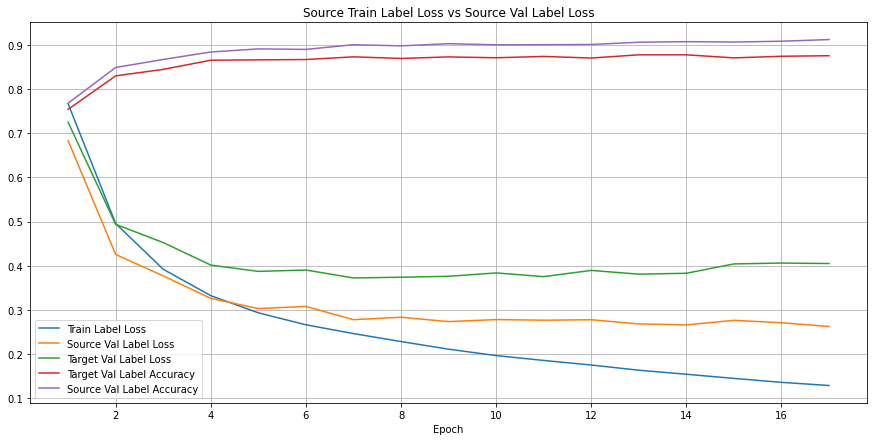

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

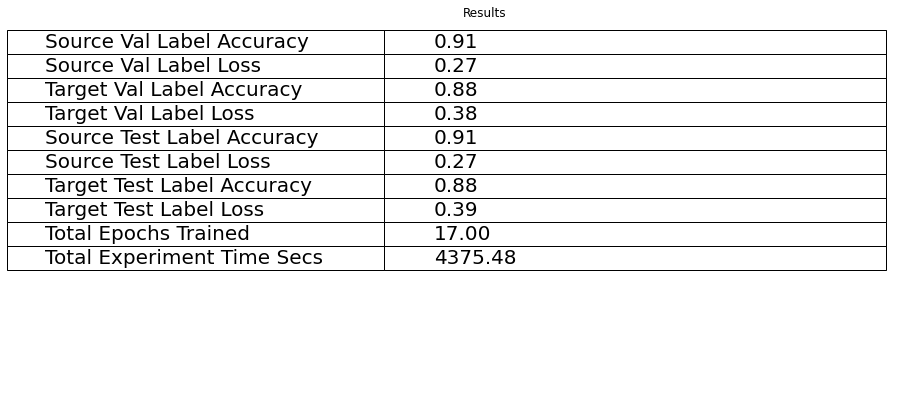

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

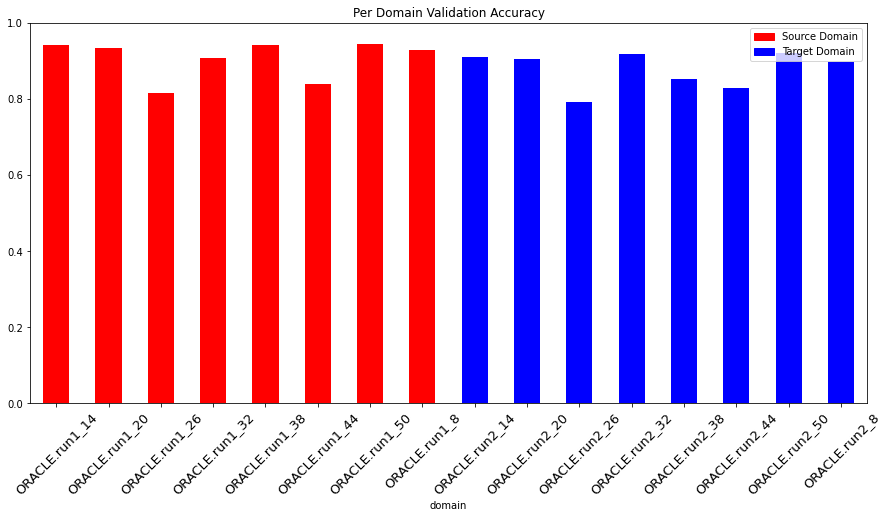

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9081705729166667 Target Test Label Accuracy: 0.8802408854166667
Source Val Label Accuracy: 0.9065755208333334 Target Val Label Accuracy: 0.8780598958333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048